In [46]:
import itertools
import matplotlib.pyplot
import pandas as pd
import shapely.geometry
from pandas import DataFrame
import numpy as np
from analysis.log_file_analyzer import *
from analysis.simulator import Simulator
import scipy
from ml.RL.bicycle_model import BicycleKinematicModel
from shapely.geometry import LineString
from shapely.geometry.polygon import LinearRing

In [47]:
reference_df = log_to_dataFrame("../test_data/kartfinal36pr3r.csv")
normalize_logs(reference_df)

traces_df = log_to_dataFrame("../test_data/200629130554_gps.log")
normalize_logs(traces_df)

laps = separate_laps(traces_df, reference_df)

reference_df['LAT'] = reference_df['LAT'].apply(lambda deg: degrees2kilometers(deg) * 1000)
reference_df['LON'] = reference_df['LON'].apply(lambda deg: degrees2kilometers(deg) * 1000)
reference_df['CRS'] = reference_df['CRS'].apply(lambda deg: np.deg2rad(deg))
# reference_df['CRS'] = reference_df['CRS'].apply(lambda deg: deg if not deg > math.pi else deg - 2*math.pi)

traces_df['LAT'] = traces_df['LAT'].apply(lambda deg: degrees2kilometers(deg) * 1000)
traces_df['LON'] = traces_df['LON'].apply(lambda deg: degrees2kilometers(deg) * 1000)
traces_df['CRS'] = traces_df['CRS'].apply(lambda deg: np.deg2rad(deg))
# traces_df['CRS'] = traces_df['CRS'].apply(lambda deg: deg if not deg > math.pi else deg - 2*math.pi)

Lap has 1399 points


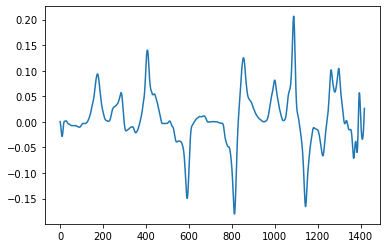

In [77]:
def n_wise(iterable, n):
    return zip(*(itertools.islice(iterable, i, None) for i in range(n)))

def find_nearest_coord(array, value):
  return min(array, key=lambda c: (c[0]- value[0])**2 + (c[1]-value[1])**2)

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2, positive=False):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
    """
    angle =  atan2( np.linalg.det(np.array(v1+v2).reshape((2,2))), np.dot(v1, v2) )
    if positive and angle < 0:
        angle += 2 * math.pi
    return angle

def get_new_steering_angle(lap, reference_lap, speed):
    points = [tuple(x) for x in lap[['LON', 'LAT']].to_numpy()]
    reference_points = [tuple(x) for x in reference_lap[['LON', 'LAT']].to_numpy()]
    reference_polygon = LinearRing(reference_df[['LON', 'LAT']].values)

    possible_angles = []
    for i in range(30,0, -1):
        possible_angles.append(i)
    for i in range(1,30):
        possible_angles.append(-i)

    # use last points to determine normal vector
    # TODO don't use last points but count in also index
    last_point1 = [reference_df['LON'].iloc[-1], reference_df['LAT'].iloc[-1]]
    last_point2 = [reference_df['LON'].iloc[-2], reference_df['LAT'].iloc[-2]]

    a = last_point2[0] - last_point1[0]
    b = last_point2[1] - last_point1[1]

    dst = distance.euclidean(last_point1, last_point2)
    distance_multiplier = math.ceil(10 / (2 * dst))

    v_normal = np.array([-b, a])
    start_point = np.array(last_point1)

    point_top = start_point + distance_multiplier * v_normal
    point_bottom = start_point - distance_multiplier * v_normal
    start_segment = segment(point_top, point_bottom)


    starting_point = points[0]
    x,y = starting_point
    xt, yt = reference_points[0]
    nearest_vector = (xt-x, yt-y)
    starting_heading_angle = angle_between((1,0), nearest_vector, True)
    model = BicycleKinematicModel(x=starting_point[0],
                                  y=starting_point[1],
                                  heading_angle=starting_heading_angle,
                                  steering_angle=0)
    actual_index = 0
    prev_point = None

    created_points=[]
    angles=[]
    steering_angles=[]
    heading_angles=[]

    while True:
        actual_state = model.get_state()
        current_x, current_y, steering_angle, heading_angle = actual_state
        created_points.append((current_x,current_y))
        steering_angles.append(steering_angle)
        heading_angles.append(heading_angle)

        actual_point = [current_x, current_y]
        if prev_point is not None:
            if intersection(segment(prev_point, actual_point), start_segment):
                print("Lap has {} points".format(actual_index))
                break

        prev_point = actual_point

        turn_angle = 0
        lowest_distance = math.inf
        for j in range(len(possible_angles)):
            copied_model = BicycleKinematicModel(x=current_x, y=current_y, steering_angle=steering_angle, heading_angle=heading_angle)
            angle = math.radians(possible_angles[j])

            copied_model.change_state(speed, angle)
            copied_model.change_state(speed, angle)
            copied_model.change_state(speed, angle)

            new_x, new_y, new_steering_angle, _ = copied_model.get_state()
            new_distance = shapely.geometry.Point([new_x,new_y]).distance(reference_polygon)
            line = LineString([[current_x,current_y], [new_x, new_y]])
            is_near_reference = reference_polygon.intersects(line) or True
            if lowest_distance > new_distance and is_near_reference and math.radians(30) > new_steering_angle > math.radians(-30):
                lowest_distance = new_distance
                turn_angle = angle

        model.change_state(speed, turn_angle)
        angles.append(turn_angle)
        actual_index += 1

    return created_points, angles, steering_angles, heading_angles

# Postup algoritmu:
# Zobrat koordinaty krivky
# Pre kazdy bod ako zaciatocny spravit cele kolecko
# Vypocet pre bod:
# Zobrat bod, vyratat uhol medzi aktualnym a najblizsim na referencnej, (tento uhol je novy steering command)
# spriemerovat uhly na rovnakom indexe (pozor, bude treba rotovat kolecka).
for value in n_wise(laps, 2):
    lap = traces_df.iloc[value[0]:value[1]]
    created_points, angles, steering_angles, heading_angles = get_new_steering_angle(lap, reference_df, 1)
    matplotlib.pyplot.plot(smooth(np.array(steering_angles), 20))
    break

In [74]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y